# Fine‑Tuning a DialoGPT Chatbot

## Instalação de pacotes

In [2]:
!pip -q install transformers datasets accelerate evaluate bitsandbytes peft gradio rouge_score --upgrade

import torch
#print('Python', sys.version)
#print('Torch', torch.__version__)
#print('GPU disponível?', torch.cuda.is_available())

from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, pipeline
from datasets import load_dataset
from transformers import BitsAndBytesConfig
import numpy as np
import evaluate
import json, pandas as pd, re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

In [3]:
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# Modelo em 4bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1.
401 Client Error. (Request ID: Root=1-6849a131-4acb72fb29f59b1146600155;243ffebc-453a-4822-bb0c-188ae10d6796)

Cannot access gated repo for url https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1/resolve/main/config.json.
Access to model mistralai/Mistral-7B-Instruct-v0.1 is restricted. You must have access to it and be authenticated to access it. Please log in.

## Curadoria e engenharia de dados

In [ ]:
# 1. Ler o JSON embutido no .txt
with open("faq-bcb.txt", "r", encoding="utf-8") as f:
    data = json.load(f)["conteudo"]

df = pd.DataFrame(data)[["pergunta", "resposta"]]

# 2. Remoção de HTML e entidades
def strip_html(x):
    txt = BeautifulSoup(x, "lxml").get_text(" ", strip=True)
    txt = re.sub(r"\s+", " ", txt)
    return txt.strip()

df["pergunta"] = df["pergunta"].apply(strip_html)
df["resposta"] = df["resposta"].apply(strip_html)

# 3. Limita respostas muito longas (opcional)
df = df[df["resposta"].str.len() < 1500]
print("Pairs ready:", len(df))

# 4. Token de fim de sequência
TOK_EOS = "</s>"

# 5. Gera coluna 'text' formatada no estilo Q&A
df["text"] = (
    "Pergunta: " + df["pergunta"].str.strip() +
    "\nResposta: " + df["resposta"].str.strip() +
    f" {TOK_EOS}"
)

df = df[["text"]].copy()

# 6. Split train/val
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)

# 7. Função auxiliar para salvar JSONL
def salvar_jsonl(df, caminho_saida):
    with open(caminho_saida, "w", encoding="utf-8") as f_out:
        for _, linha in df.iterrows():
            texto = linha["text"].strip()

            # Garante que termina com </s>
            if not texto.endswith(TOK_EOS):
                texto += f" {TOK_EOS}"

            json.dump({"text": texto}, f_out, ensure_ascii=False)
            f_out.write("\n")

# 8. Salvar JSONL corrigidos
salvar_jsonl(train_df, "train.jsonl")
salvar_jsonl(val_df,   "val.jsonl")


Pairs ready: 1137


<ipython-input-9-a3be67e11c61>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text"] = (


In [ ]:
!head train.jsonl


{"text": "Pergunta: Vítima não reconhece uma compra em maquininha de cartão\nResposta: ​Caso não reconheça determinada compra feita em maquininha de cartão, recomenda-se conversar com o lojista ou entrar em contato com o banco. Se a situação não for resolvida, a vítima pode: Procurar o Procon de seu estado ou o Poder Judiciário; ou Registrar uma reclamação no BC. Dicas: Antes de digitar a senha ou de aproximar o cartão para pagar, conferir sempre se o visor da maquininha de cartão está funcionando corretamente e se o valor digitado está correto; Desabilitar a função de pagamento por aproximação se não estiver segura com essa funcionalidade. </s>"}
{"text": "Pergunta: Instituições financeiras associadas ao FGC\nResposta: ​São obrigatoriamente associadas ao Fundo Garantidor de Crédito (FGC) a Caixa Econômica Federal, os bancos múltiplos, os bancos comerciais, os bancos de investimento, os bancos de desenvolvimento, as sociedades de crédito, financiamento e investimento, as sociedades de 

In [ ]:
from datasets import load_dataset

data_files = {
    "train": "train.jsonl",
    "validation": "val.jsonl"
}

ds = load_dataset("json", data_files=data_files)
print(ds["train"][0])


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

{'text': 'Pergunta: Vítima não reconhece uma compra em maquininha de cartão\nResposta: \u200bCaso não reconheça determinada compra feita em maquininha de cartão, recomenda-se conversar com o lojista ou entrar em contato com o banco. Se a situação não for resolvida, a vítima pode: Procurar o Procon de seu estado ou o Poder Judiciário; ou Registrar uma reclamação no BC. Dicas: Antes de digitar a senha ou de aproximar o cartão para pagar, conferir sempre se o visor da maquininha de cartão está funcionando corretamente e se o valor digitado está correto; Desabilitar a função de pagamento por aproximação se não estiver segura com essa funcionalidade. </s>'}


In [ ]:
from datasets import load_dataset
from transformers import (AutoTokenizer, AutoModelForCausalLM,
                          TrainingArguments, Trainer)
from peft import LoraConfig, get_peft_model
from huggingface_hub import login
login(os.environ["HF_TOKEN"])

from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    TrainingArguments, Trainer, BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model

# 1. Dataset
data_files = {"train": "train.jsonl", "validation": "val.jsonl"}
ds = load_dataset("json", data_files=data_files)

# 2. Tokenizer
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
TOK_EOS = tokenizer.eos_token

# 3. Tokenização
def tok(batch):
    out = tokenizer(batch["text"], truncation=True, max_length=512, padding="max_length")
    out["labels"] = out["input_ids"]
    return out

tok_train = ds["train"].map(tok, batched=True, remove_columns=["text"])
tok_val   = ds["validation"].map(tok, batched=True, remove_columns=["text"])

# 4. Carregamento do modelo quantizado em 4bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype="float16"
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# 5. Aplicar LoRA no modelo quantizado
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],  # Pode incluir outros, como "k_proj", "o_proj" se necessário
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# 6. TrainingArguments
import os
os.environ["WANDB_DISABLED"] = "true"

args = TrainingArguments(
    output_dir="mistral_ckpt",
    eval_strategy="epoch",
    logging_steps=20,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    num_train_epochs=10,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    learning_rate=2e-5,
    save_total_limit=2,
    bf16=False,
    fp16=True,
    report_to="none"
)

# 7. Treinamento
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tok_train,
    eval_dataset=tok_val
)
trainer.train()

# 8. Salvar adaptador LoRA e tokenizer
trainer.save_model("chefbot_bcb_mistral")
tokenizer.save_pretrained("chefbot_bcb_mistral")



Map:   0%|          | 0/966 [00:00<?, ? examples/s]

Map:   0%|          | 0/171 [00:00<?, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.0470


Epoch,Training Loss,Validation Loss
1,0.588700,0.626703
2,0.605200,0.603322
3,0.525800,0.594642
4,0.520700,0.590507
5,0.559200,0.589673
6,0.532200,0.589075
7,0.551200,0.589884
8,0.565500,0.590388
9,0.515100,0.592558
10,0.597000,0.594522


('chefbot_bcb_mistral/tokenizer_config.json',
 'chefbot_bcb_mistral/special_tokens_map.json',
 'chefbot_bcb_mistral/chat_template.jinja',
 'chefbot_bcb_mistral/tokenizer.model',
 'chefbot_bcb_mistral/added_tokens.json',
 'chefbot_bcb_mistral/tokenizer.json')

In [ ]:
%cp -r /content/chefbot_bcb_mistral/ /content/drive/MyDrive/

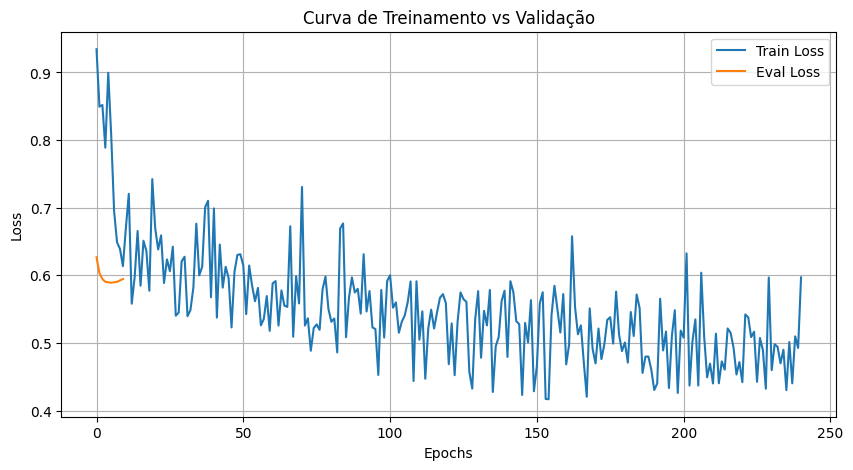

In [ ]:
import matplotlib.pyplot as plt

# Extrai o histórico de loss
logs = trainer.state.log_history

train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss  = [log["eval_loss"] for log in logs if "eval_loss" in log]

# Plota
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Eval Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Curva de Treinamento vs Validação")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Pipeline de geração
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map="auto")

# Teste de prompt
prompt = "Por que preciso de nível prata ou ouro, além da verificação em duas etapas (2FA), para ver o Registrato com a conta Gov.br?\nResposta:"
output = pipe(prompt, max_new_tokens=150, temperature=1.2)

print(output[0]['generated_text'])

Device set to use cuda:0


Por que preciso de nível prata ou ouro, além da verificação em duas etapas (2FA), para ver o Registrato com a conta Gov.br?
Resposta: Não precisa de nível de ouro ou prata. As autorizações serão realizadas pelo nível verde (tamanho 2, verde no círculo branco). Esperamos que esse padrão possa ser aplicado ao contado Gov.br e demais contadados da FEBRAS, assim que se possível. Basta escolher a autorização na guia "Vê seu Gov" e selecionar o nível verde. Somente para exemplo, as autorizações foram feitas por conta Gov.br, nível bronze (azul) no c


In [ ]:
"""from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# Caminho para o adaptador treinado
adapter_path = "chefbot_bcb_lora"

# 1. Carrega o modelo base
base_model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small")

# 2. Aplica o adaptador LoRA treinado
model = PeftModel.from_pretrained(base_model, adapter_path)

# 3. Tokenizer
tokenizer = AutoTokenizer.from_pretrained(adapter_path)

# 4. Cria o pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# 5. Geração com prompt
prompt = "Pergunta: O que é Registrato?\nResposta:"
output = pipe(prompt, max_new_tokens=100, temperature=0.7)

# 6. Exibe o resultado
print(output[0]["generated_text"])
"""

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

ValueError: Can't find 'adapter_config.json' at 'chefbot_bcb_lora'

In [ ]:
#!cp -r /content/chefbot_bcb_lora/ /content/drive/MyDrive/

In [ ]:
import evaluate

rouge = evaluate.load("rouge")
reference = "O Registrato é um sistema do Banco Central que permite ao cidadão consultar gratuitamente..."
prediction = output[0]['generated_text'].split("Resposta:")[-1].strip()

results = rouge.compute(predictions=[prediction], references=[reference])
print(results)
